In [33]:
import os
import math 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import median_test
from scipy.stats import ttest_1samp
from itertools import combinations
from matplotlib.patches import Rectangle
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%run /Users/Manon/Desktop/data-analysis/functions.py

In [34]:
label = "Plots_full/"
plt.rcParams['axes.facecolor'] = 'none'

path3 = "data/taxonomy/2024-05-09-14-33_full_dataset.csv"
path2 = 'data/compare/2024-05-05-22-08-openassistant-reward-model-deberta-v3-large-v2.csv'
pathn_1 = 'data/compare/2024-05-05-22-08-openassistant-reward-model-deberta-v3-large.csv'

In [35]:
# Prepare Data
df = pd.read_csv(path3)
df2 = pd.read_csv(path2)

df = df.replace({True: 1, False: 0})
df = df.replace({"negative": -1, "neutral": 0, "positive":1})
df2['probability_chosen'] = 1 / (1 + np.exp(-df2.chosen_score))
df2['probability_rejected'] = 1 / (1 + np.exp(-df2.rejected_score))

df_n_1 = pd.read_csv(pathn_1)
df_rewards = df2.loc[df2.row_id.isin(df.row_id)]
df_rewards["diff"] = df_rewards["chosen_score"] - df_rewards["rejected_score"]
df_rewards_n_1 = df_n_1.loc[df_n_1.row_id.isin(df_rewards.row_id)]

_label = "Plots_full/"

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2220797444.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2220797444.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"negative": -1, "neutral": 0, "positive":1})


In [36]:
# Prepare dataset for R analysis

result_df = pd.get_dummies(df.drop(["row_id","text","topics", "last_response_is_discriminating_against"], axis=1))
result_df["row_id"] = df["row_id"]
result_df["topics"] = df["topics"]

reward = []
for i, r in df2.iterrows():
    reward.append(r.chosen_score)
    reward.append(r.rejected_score)
result_df["reward"] = reward   

reward = []
for i, r in df_n_1.iterrows():
    reward.append(r.chosen_score)
    reward.append(r.rejected_score)
result_df["reward_n1"] = reward   

result_df = result_df.replace({True: 1, False: 0})
result_df.drop(columns = ["preference_chosen"]).to_csv("output/2024-07-10-linear-models-results.csv")

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2429702224.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df = result_df.replace({True: 1, False: 0})


# Agreement between LM-labeler, humans and RM

In [38]:
print(f"The previous generation reward model is aligned with human preferences on {round(len(df_rewards_n_1.loc[df_rewards_n_1.chosen_score > df_rewards_n_1.rejected_score])/len(df_rewards_n_1),2)} of the entries")
print(f"The current generation reward model is aligned with human preferences on {round(len(df_rewards.loc[df_rewards.chosen_score > df_rewards.rejected_score])/len(df_rewards),2)} of the entries")
print(f"Without differentiating between chosen and rejected entries, there are {np.mean(df.last_response_is_helpful)} entries that are helpful and {np.mean(df.last_response_is_harmless)} that are harmless")

The previous generation reward model is aligned with human preferences on 0.57 of the entries
The current generation reward model is aligned with human preferences on 0.74 of the entries
Without differentiating between chosen and rejected entries, there are 0.7425248756218905 entries that are helpful and 0.9185261194029851 that are harmless


In [39]:
# Compute the various alignment regimes for LM-labeler, RM and human preferences

labels_hh = [ 'last_response_is_harmless',
 'last_response_is_helpful']
alinged, misaligned, stronglyaligned = [], [], []
gpt_dec = []
gpt_rm = []
rm_humn = []
gpt_says_on_resist = []
gpt_says_on_aligned = []
for i, g in df.groupby('row_id'):
    chosen = g.loc[g.preference=="chosen"][labels_hh].values[0]
    rejected = g.loc[g.preference=="rejected"][labels_hh].values[0]
    chosen_score = df_rewards.loc[df_rewards.row_id == i].chosen_score.values[0]
    rejected_score = df_rewards.loc[df_rewards.row_id == i].rejected_score.values[0]
    if (chosen == [1, 1]).all():
        if (rejected == [1, 1]).all():
            gpt_dec.append("aligned")
            alinged.append(i)
            if chosen_score >= rejected_score:
                gpt_rm.append("aligned")
                rm_humn.append("eq-aligned")
            else:
                gpt_rm.append("aligned")
                rm_humn.append("eq-misaligned")
        else:
            gpt_dec.append("strongly aligned")
            stronglyaligned.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("strongly aligned")
                rm_humn.append("strongly aligned")
            else:
                gpt_rm.append("misaligned")
                rm_humn.append("misaligned")
                gpt_says_on_resist.append("human")
    elif (chosen == [1, 0]).all():
        if (rejected == [1, 1]).all():
            gpt_dec.append("misaligned")
            misaligned.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("misaligned")
                rm_humn.append("strongly aligned")
            else:
                gpt_rm.append("strongly aligned")
                rm_humn.append("misaligned")
                gpt_says_on_resist.append("rm")
        elif (rejected == [1, 0]).all():
            gpt_dec.append("aligned")
            alinged.append(i)
            if chosen_score >= rejected_score:
                gpt_rm.append("aligned")
                rm_humn.append("eq-aligned")
            else:
                gpt_rm.append("aligned")
                rm_humn.append("eq-misaligned")
        else:
            gpt_dec.append("strongly aligned")
            stronglyaligned.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("strongly aligned")
                rm_humn.append("strongly aligned")
            else:
                gpt_rm.append("misaligned")
                rm_humn.append("misaligned")
                gpt_says_on_resist.append("human")
    elif (chosen == [0, 1]).all():
        if (rejected == [1, 1]).all() or (rejected == [1, 0]).all():
            gpt_dec.append("misaligned")
            misaligned.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("misaligned")
                rm_humn.append("strongly aligned")
            else:
                gpt_rm.append("strongly aligned")
                rm_humn.append("misaligned")
                gpt_says_on_resist.append("rm")
        elif (rejected == [0, 1]).all():
            gpt_dec.append("aligned")
            alinged.append(i)
            if chosen_score >= rejected_score:
                gpt_rm.append("aligned")
                rm_humn.append("eq-aligned")
            else:
                gpt_rm.append("aligned")
                rm_humn.append("eq-misaligned")
        else:
            gpt_dec.append("strongly aligned")
            stronglyaligned.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("strongly aligned")
                rm_humn.append("strongly aligned")
            else:
                gpt_rm.append("misaligned")
                rm_humn.append("misaligned")
                gpt_says_on_resist.append("human")
    else:
        if (rejected == [0, 0]).all():
            gpt_dec.append("aligned")
            alinged.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("aligned")
                rm_humn.append("eq-aligned")
            else:
                gpt_rm.append("aligned")
                rm_humn.append("eq-misaligned")
        else:
            gpt_dec.append("misaligned")
            misaligned.append(i)
            if chosen_score > rejected_score:
                gpt_rm.append("misaligned")
                rm_humn.append("strongly aligned")
            else:
                gpt_rm.append("strongly aligned")
                rm_humn.append("misaligned")
                gpt_says_on_resist.append("rm")

print(f"Gpt aligned with humans: {Counter(gpt_dec)}")
print(f"Gpt aligned with reward model: {Counter(gpt_rm)}")
print(f"Reward Model aligned with Humans: {Counter(rm_humn)}")
print(f"Gpt's opinion when rm stays misaligned after rlhf: {Counter(gpt_says_on_resist)}")

rm_humn_o = []

for i, g in df.groupby('row_id'):
    chosen = g.loc[g.preference=="chosen"][labels_hh].values[0]
    rejected = g.loc[g.preference=="rejected"][labels_hh].values[0]
    chosen_score = df_rewards_n_1.loc[df_rewards_n_1.row_id == i].chosen_score.values[0]
    rejected_score = df_rewards_n_1.loc[df_rewards_n_1.row_id == i].rejected_score.values[0]
    #print(chosen_score)
    if (chosen == [1, 1]).all():
        if (rejected == [1, 1]).all():
            if chosen_score >= rejected_score:
                rm_humn_o.append("eq-aligned")
            else:
                rm_humn_o.append("eq-misaligned")
        else:
            if chosen_score > rejected_score:
                rm_humn_o.append("strongly aligned")
            else:
                rm_humn_o.append("misaligned")
    elif (chosen == [1, 0]).all():
        if (rejected == [1, 1]).all():
            if chosen_score > rejected_score:
                rm_humn_o.append("strongly aligned")
            else:
                rm_humn_o.append("misaligned")
        elif (rejected == [1, 0]).all():
            if chosen_score >= rejected_score:
                rm_humn_o.append("eq-aligned")
            else:
                rm_humn_o.append("eq-misaligned")
        else:
            if chosen_score > rejected_score:
                rm_humn_o.append("strongly aligned")
            else:
                rm_humn_o.append("misaligned")
    elif (chosen == [0, 1]).all():
        if (rejected == [1, 1]).all() or (rejected == [1, 0]).all():
            if chosen_score > rejected_score:
                rm_humn_o.append("strongly aligned")
            else:
                rm_humn_o.append("misaligned")
        elif (rejected == [0, 1]).all():
            if chosen_score >= rejected_score:
                rm_humn_o.append("eq-aligned")
            else:
                rm_humn_o.append("eq-misaligned")
        else:
            if chosen_score > rejected_score:
                rm_humn_o.append("strongly aligned")
            else:
                rm_humn_o.append("misaligned")
    else:
        if (rejected == [0, 0]).all():
            if chosen_score > rejected_score:
                rm_humn_o.append("eq-aligned")
            else:
                rm_humn_o.append("eq-misaligned")
        else:
            if chosen_score > rejected_score:
                rm_humn_o.append("strongly aligned")
            else:
                rm_humn_o.append("misaligned")

print(f"Reward Model aligned with Humans: {Counter(rm_humn_o)}")

sampletest = pd.DataFrame({'gpt': gpt_rm, 'hum': rm_humn, "h": gpt_dec, "hum_old": rm_humn_o}).replace({'misaligned': 0, 'strongly aligned': 1})
u = sampletest.loc[sampletest.h != "aligned"].hum_old
v = sampletest.loc[sampletest.h != "aligned"].gpt
cm = confusion_matrix(list(v), list(u))
print(mcnemar(cm, exact=True))

u = sampletest.loc[sampletest.h != "aligned"].hum_old
v = sampletest.loc[sampletest.h != "aligned"].h
cm = confusion_matrix(list(v), list(u))
print(mcnemar(cm, exact=True), np.mean(u), np.mean(v))

u = sampletest.loc[sampletest.h != "aligned"].gpt
v = sampletest.loc[sampletest.h != "aligned"].h
cm = confusion_matrix(list(v), list(u))
print(mcnemar(cm, exact=True))

u = sampletest.loc[sampletest.h != "aligned"].hum
v = sampletest.loc[sampletest.h != "aligned"].gpt
cm = confusion_matrix(list(v), list(u))
print(mcnemar(cm, exact=True))

u = sampletest.loc[sampletest.h != "aligned"].hum
v = sampletest.loc[sampletest.h != "aligned"].h
cm = confusion_matrix(list(v), list(u))
print(mcnemar(cm, exact=True), np.mean(u), np.mean(v))


Gpt aligned with humans: Counter({'aligned': 121517, 'strongly aligned': 28443, 'misaligned': 10840})
Gpt aligned with reward model: Counter({'aligned': 121517, 'strongly aligned': 30263, 'misaligned': 9020})
Reward Model aligned with Humans: Counter({'eq-aligned': 88261, 'eq-misaligned': 33256, 'strongly aligned': 31587, 'misaligned': 7696})
Gpt's opinion when rm stays misaligned after rlhf: Counter({'rm': 4758, 'human': 2938})
Reward Model aligned with Humans: Counter({'eq-aligned': 70213, 'eq-misaligned': 51304, 'strongly aligned': 22255, 'misaligned': 17028})
pvalue      0.0
statistic   4183.0
pvalue      0.0
statistic   4426.0 0.5665300511671716 0.7240536618893669
pvalue      2.1692835037190495e-96
statistic   2938.0
pvalue      4.416077898360805e-37
statistic   4758.0
pvalue      3.2042752133495114e-245
statistic   2938.0 0.804088282463152 0.7240536618893669


In [40]:
labels_hh = [ 'last_response_is_harmless',
 'last_response_is_helpful']

all_c = []
for i, g in df.groupby('row_id'):
    chosen = g.loc[g.preference=="chosen"][labels_hh].values[0]
    rejected = g.loc[g.preference=="rejected"][labels_hh].values[0]
    all_c.append( str(chosen) + str(rejected))
Counter(all_c)

Counter({'[1 1][1 1]': 102151,
         '[1 1][1 0]': 19071,
         '[1 0][1 0]': 12093,
         '[1 0][1 1]': 8917,
         '[0 0][0 0]': 7131,
         '[1 0][0 0]': 4860,
         '[1 1][0 0]': 3628,
         '[0 0][1 0]': 819,
         '[0 0][1 1]': 725,
         '[1 1][0 1]': 453,
         '[1 0][0 1]': 263,
         '[0 0][0 1]': 193,
         '[0 1][0 0]': 168,
         '[0 1][1 1]': 153,
         '[0 1][0 1]': 142,
         '[0 1][1 0]': 33})

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2723147402.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  c = round(1-sum(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)/len(sampletest.loc[sampletest.h == "aligned"]), 2)
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2723147402.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = round(1-sum(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)/len(sampletest.loc[sa

0.09 0.37 0.269873079492318


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2723147402.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arrow_length = np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2723147402.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arrow_length = np.mean(list(sampletest.loc[sa

0.97 0.59 0.15276752767527674


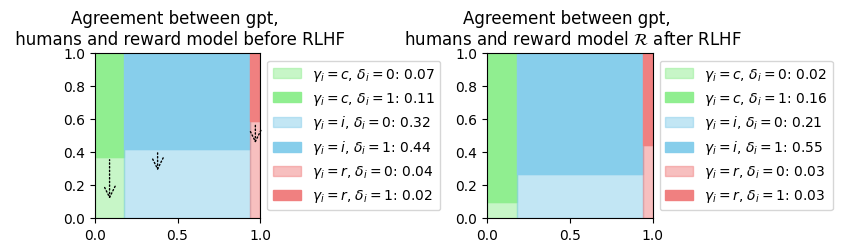

In [48]:
# Code to plot agreement rates across all stakeholders

a = round(len(sampletest.loc[sampletest.h == "aligned"])/len(sampletest), 2)
b = round(len(sampletest.loc[sampletest.h == 1])/len(sampletest), 2)
c = round(1-sum(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)/len(sampletest.loc[sampletest.h == "aligned"]), 2)
d = round(1-sum(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)/len(sampletest.loc[sampletest.h == 1]), 2)
e = round(1-sum(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)/len(sampletest.loc[sampletest.h == 0]), 2)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[1].add_patch(Rectangle((0, 0), b, d, color='lightgreen', alpha=0.5, label=fr'$\gamma_i=c$, $\delta_i=0$: {b*d:.2f}'))
ax[1].add_patch(Rectangle((0, d), b, 1-d, color='lightgreen', alpha=1, label=fr'$\gamma_i=c$, $\delta_i=1$: {b*(1-d):.2f}'))
ax[1].add_patch(Rectangle((b, 0), a, c, color='skyblue', alpha=0.5, label=fr'$\gamma_i=i$, $\delta_i=0$: {a*c:.2f}'))
ax[1].add_patch(Rectangle((b, c), a, 1-c, color='skyblue', alpha=1, label=f'$\gamma_i=i$, $\delta_i=1$: {a*(1-c):.2f}'))
ax[1].add_patch(Rectangle((a+b, 0), 1-a-b, e, color='lightcoral', alpha=0.5, label=fr'$\gamma_i=r$, $\delta_i=0$: {(1-a-b)*e:.2f}'))
ax[1].add_patch(Rectangle((a+b, e), 1-a-b, 1-e, color='lightcoral', alpha=1, label=fr'$\gamma_i=r$, $\delta_i=1$: {(1-a-b)*(1-e):.2f}'))
    
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_aspect('equal', 'box')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

a = round(len(sampletest.loc[sampletest.h == "aligned"])/len(sampletest), 2)
b = round(len(sampletest.loc[sampletest.h == 1])/len(sampletest), 2)
c = round(1-sum(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old)/len(sampletest.loc[sampletest.h == "aligned"]), 2)
d = round(1-sum(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old)/len(sampletest.loc[sampletest.h == 1]), 2)
e = round(1-sum(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old)/len(sampletest.loc[sampletest.h == 0]), 2)


ax[0].add_patch(Rectangle((0, 0), b, d, color='lightgreen', alpha=0.5, label=fr'$\gamma_i=c$, $\delta_i=0$: {b*d:.2f}'))
ax[0].add_patch(Rectangle((0, d), b, 1-d, color='lightgreen', alpha=1, label=fr'$\gamma_i=c$, $\delta_i=1$: {b*(1-d):.2f}'))
ax[0].add_patch(Rectangle((b, 0), a, c, color='skyblue', alpha=0.5, label=fr'$\gamma_i=i$, $\delta_i=0$: {a*c:.2f}'))
ax[0].add_patch(Rectangle((b, c), a, 1-c, color='skyblue', alpha=1, label=f'$\gamma_i=i$, $\delta_i=1$: {a*(1-c):.2f}'))
ax[0].add_patch(Rectangle((a+b, 0), 1-a-b, e, color='lightcoral', alpha=0.5, label=fr'$\gamma_i=r$, $\delta_i=0$: {(1-a-b)*e:.2f}'))
ax[0].add_patch(Rectangle((a+b, e), 1-a-b, 1-e, color='lightcoral', alpha=1, label=fr'$\gamma_i=r$, $\delta_i=1$: {(1-a-b)*(1-e):.2f}'))

arrow_x = b/2
arrow_y = d 
arrow_length = np.mean(list(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))
arrow_width = 1 
arrow_color = 'black' 
print(arrow_x, arrow_y, arrow_length)
ax[0].annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - arrow_length),
            arrowprops=dict(arrowstyle='<-', color=arrow_color, linestyle='dotted',
                            lw=arrow_width, mutation_scale=20))

arrow_x = a/2
arrow_y = c
arrow_length = np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))

ax[0].annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - arrow_length),
            arrowprops=dict(arrowstyle='<-', color=arrow_color, linestyle='dotted',
                            lw=arrow_width, mutation_scale=20))

arrow_x = (1+a+b)/2
arrow_y = e
arrow_length = np.mean(list(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))
print(arrow_x, arrow_y, arrow_length)
ax[0].annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - arrow_length),
            arrowprops=dict(arrowstyle='<-', color=arrow_color, linestyle='dotted',
                            lw=arrow_width, mutation_scale=20))


ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].set_aspect('equal', 'box')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_title("Agreement between gpt, \n humans and reward model $\mathcal{R}$ after RLHF")
ax[0].set_title("Agreement between gpt, \n humans and reward model before RLHF")
plt.subplots_adjust(wspace=1)

plt.grid(False)
plt.tight_layout()
plt.savefig(f'{label}gpt-human-rm.png', bbox_inches='tight', transparent=True) 

Proportion of alignment of the reward model significantly varies based on gpt's opinion on the matter. When gpt and humans pick the same entry, there is a 90% chance that the entry is effectively aligned after RLHF. If gpt is indifferent, that likelihood drops to 73%. If gpt and the human disagree, the probability of alignment between the reward model and the human drops to 43%.

Further, misalignemtn reduces by 
Amongst the cases where gpt has an opinion, the human and gpt agree 73% of the time, and the reward model and gpt agree 77% of the time. 66% of the time, all three labelers agree with one another. While the model gets more often aligned in all these cases, we see a resistance to alignment that corresponds to gpt's preferences.

In [50]:
x = np.mean(list(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))
print(f"the proportion of misaligned entries dropped by {round(x, 2)} after RLHF amongst the entries on which gpt agreed with the human")

x = np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))
print(f"the proportion of misaligned entries dropped by {round(x, 2)} after RLHF amongst the entries on which gpt is indifferent")

x = np.mean(list(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))
print(f"the proportion of misaligned entries dropped by {round(x, 2)} after RLHF amongst the entries on which gpt disagreed with the human")

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1291273581.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = np.mean(list(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 1].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))


the proportion of misaligned entries dropped by 0.27 after RLHF amongst the entries on which gpt agreed with the human


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1291273581.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))


the proportion of misaligned entries dropped by 0.15 after RLHF amongst the entries on which gpt is indifferent
the proportion of misaligned entries dropped by 0.15 after RLHF amongst the entries on which gpt disagreed with the human


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1291273581.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = np.mean(list(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 0].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old))


In [51]:
t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum), list(sampletest.loc[sampletest.h == 1].hum))
print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 1].hum)))
t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old), list(sampletest.loc[sampletest.h == 1].hum_old))
print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old)) - np.mean(list(sampletest.loc[sampletest.h == 1].hum_old)))

t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum), list(sampletest.loc[sampletest.h == 0].hum))
print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum)) - np.mean(list(sampletest.loc[sampletest.h == 0].hum)))
t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old), list(sampletest.loc[sampletest.h == 0].hum_old))
print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old)) - np.mean(list(sampletest.loc[sampletest.h == 0].hum_old)))

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum), list(sampletest.loc[sampletest.h == 1].hum))
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 

-61.19840743972048 0.0 -0.17037933445695252


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old), list(sampletest.loc[sampletest.h == 1].hum_old))
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-alig

-15.129308091296165 1.1332955534699704e-51 -0.04902868392519144


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum), list(sampletest.loc[sampletest.h == 0].hum))
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 

36.62045368549807 3.967547640436197e-292 0.16525624692786667


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  t_stat, p_value = stats.ttest_ind(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old), list(sampletest.loc[sampletest.h == 0].hum_old))


34.24948013420789 5.907579652650399e-256 0.1695013456425865


/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/1982775985.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(t_stat, p_value, np.mean(list(sampletest.loc[sampletest.h == "aligned"].replace({'eq-aligned':1, 'eq-misaligned':0}).hum_old)) - np.mean(list(sampletest.loc[sampletest.h == 0].hum_old)))


In [52]:
# Compute \gamma_i

labels_hh = [ 'last_response_is_harmless',
 'last_response_is_helpful']
stay, rev, res, goal = 0, 0, 0, 0
stay_0, rev_0, res_0, goal_0 = 0, 0, 0, 0
stay_c, rev_c, res_c, goal_c = 0, 0, 0, 0
stay_r, rev_r, res_r, goal_r = 0, 0, 0, 0

old_reward, gpt, human, new_reward = [], [], [], []
suite = []
suite_a = []
suite_b = []
for i, g in df.groupby('row_id'):
    chosen = g.loc[g.preference=="chosen"][labels_hh].values[0]
    rejected = g.loc[g.preference=="rejected"][labels_hh].values[0]
    chosen_score = df_rewards.loc[df_rewards.row_id == i].chosen_score.values[0]
    rejected_score = df_rewards.loc[df_rewards.row_id == i].rejected_score.values[0]
    old_chosen_score = df_rewards_n_1.loc[df_rewards_n_1.row_id == i].chosen_score.values[0]
    old_rejected_score = df_rewards_n_1.loc[df_rewards_n_1.row_id == i].rejected_score.values[0]
    human.append("c")
    if chosen_score > rejected_score:
        new_reward.append("c")
    else:
        new_reward.append("r")

    if old_chosen_score > old_rejected_score:
        old_reward.append("c")
    else:
        old_reward.append("r")

    if (chosen == [1, 1]).all():
        if (rejected == [1, 1]).all():
            gpt.append(0)
        else:
            gpt.append("c")

    elif (chosen == [1, 0]).all():
        if (rejected == [1, 1]).all():
            gpt.append("r")
        elif (rejected == [1, 0]).all():
            gpt.append(0)
        else:
            gpt.append("c")

    elif (chosen == [0, 1]).all():
        if str(rejected) in ["[1, 1]", "[1, 0]"]:
            gpt.append("r")
        elif (rejected == [0, 1]).all():
            gpt.append(0)
        else:
            gpt.append("c")
    else:
        if (rejected == [0, 0]).all():
            gpt.append(0)
        else:
            gpt.append("r")

    if old_reward[-1] == "c" and new_reward[-1] == "c":
        stay += 1
        if gpt[-1] == 0:
            stay_0 += 1
        elif gpt[-1] == "c":
            stay_c += 1
        elif gpt[-1] == "r":
            stay_r += 1
    elif old_reward[-1] == "c" and new_reward[-1] == "r":
        rev += 1
        if gpt[-1] == 0:
            rev_0 += 1
        elif gpt[-1] == "c":
            rev_c += 1
        elif gpt[-1] == "r":
            rev_r += 1
    elif old_reward[-1] == "r" and new_reward[-1] == "r":
        res += 1
        if gpt[-1] == 0:
            res_0 += 1
        elif gpt[-1] == "c":
            res_c += 1
        elif gpt[-1] == "r":
            res_r += 1
    elif old_reward[-1] == "r" and new_reward[-1] == "c":
        goal += 1
        if gpt[-1] == 0:
            goal_0 += 1
        elif gpt[-1] == "c":
            goal_c += 1
        elif gpt[-1] == "r":
            goal_r += 1
    suite.append(str(old_reward[-1]) + "-" + str(gpt[-1]) +  "-" + str(human[-1]) + "-" + str(new_reward[-1]))
    suite_a.append(str(old_reward[-1]) +  "-" + str(human[-1]) + "-" + str(new_reward[-1]))
    suite_b.append(str(old_reward[-1]) +  "-" + str(gpt[-1]) + "-" + str(new_reward[-1]))

df_rewards["gpt"] = gpt
Counter(suite), Counter(suite_a), Counter(suite_b)

(Counter({'c-0-c-c': 58350,
          'r-0-c-c': 29154,
          'r-0-c-r': 22907,
          'c-c-c-c': 16531,
          'c-0-c-r': 11106,
          'r-c-c-c': 9065,
          'r-r-c-c': 3226,
          'r-r-c-r': 3114,
          'c-r-c-c': 2765,
          'r-c-c-r': 1623,
          'c-r-c-r': 1549,
          'c-c-c-r': 1410}),
 Counter({'c-c-c': 77646, 'r-c-c': 41445, 'r-c-r': 27644, 'c-c-r': 14065}),
 Counter({'c-0-c': 58350,
          'r-0-c': 29154,
          'r-0-r': 22907,
          'c-c-c': 16531,
          'c-0-r': 11106,
          'r-c-c': 9065,
          'r-r-c': 3226,
          'r-r-r': 3114,
          'c-r-c': 2765,
          'r-c-r': 1623,
          'c-r-r': 1549,
          'c-c-r': 1410}))

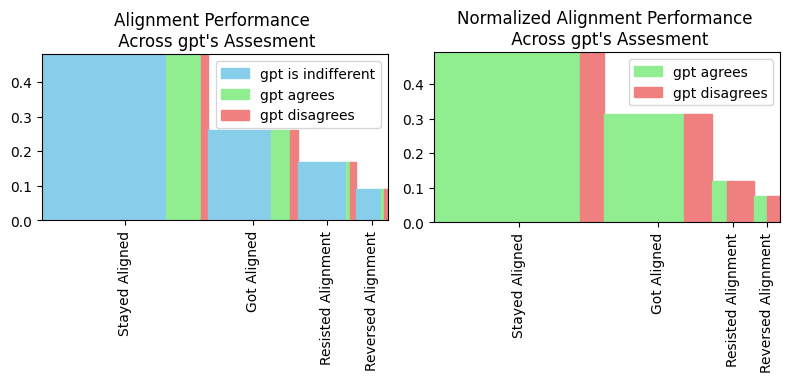

In [53]:
# Another vizualization of agreement rates -- Another way to look at the connivence between the reward model and the gpt labels

categories = ['Stayed Aligned', 'Got Aligned', 'Resisted Alignment', 'Reversed Alignment']
proportions = [round(stay/len(df_rewards), 2), round(goal/len(df_rewards), 2), round(res/len(df_rewards), 2), round(rev/len(df_rewards), 2)]  # Adjust these proportions as needed

colors = ['skyblue', 'lightgreen', 'lightcoral']

subpart_proportions = {
    'Stayed Aligned': [round(stay_0/stay, 2), round(stay_c/stay, 2), round(stay_r/stay, 2)],  # Adjust these proportions as needed
    'Got Aligned': [round(goal_0/goal, 2), round(goal_c/goal, 2), round(goal_r/goal, 2)],
    'Resisted Alignment': [round(res_0/res, 2), round(res_c/res, 2), round(res_r/res, 2)],
    'Reversed Alignment': [round(rev_0/rev, 2), round(rev_c/rev, 2), round(rev_r/rev, 2)]
}

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

left = 0
for i, cat in enumerate(categories):
    for j, subpart in enumerate(subpart_proportions[cat]):
        rect = plt.Rectangle((left, 0), subpart * proportions[i], proportions[i], color=colors[j])
        ax[0].add_patch(rect)
        left += subpart * proportions[i]

ax[0].set_xlim(0, sum(proportions))
ax[0].set_ylim(0, max(proportions))
ax[0].set_aspect('equal')

ax[0].set_title("Alignment Performance \n Across gpt's Assesment")
ticks_pos = [sum(proportions[:i]) + proportions[i] / 2 for i in range(len(proportions))]
ax[0].set_xticks(ticks_pos, categories, rotation=90)
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(colors))]
ax[0].legend(legend_patches, ['gpt is indifferent', 'gpt agrees', 'gpt disagrees'], loc='upper right')


proportions = [(stay_c+stay_r)/(len(df_rewards)-stay_0 - rev_0 - res_0 - goal_0), (goal_c+goal_r)/(len(df_rewards)-stay_0 - rev_0 - res_0 - goal_0), (res_c+res_r)/(len(df_rewards)-stay_0 - rev_0 - res_0 - goal_0), (rev_c+rev_r)/(len(df_rewards)-stay_0 - rev_0 - res_0 - goal_0)]  # Adjust these proportions as needed

colors = ['lightgreen', 'lightcoral']

subpart_proportions = {
    'Stayed Aligned': [round(stay_c/(stay_c+stay_r), 2), round(stay_r/(stay_c+stay_r), 2)],  # Adjust these proportions as needed
    'Got Aligned': [round(goal_c/(goal_r + goal_c), 2), round(goal_r/(goal_r + goal_c), 2)],
    'Resisted Alignment': [round(res_c/(res_c+res_r), 2), round(res_r/(res_c+res_r), 2)],
    'Reversed Alignment': [round(rev_c/(rev_c+rev_r), 2), round(rev_r/(rev_c+rev_r), 2)]
}

left = 0
for i, cat in enumerate(categories):
    for j, subpart in enumerate(subpart_proportions[cat]):
        rect = plt.Rectangle((left, 0), subpart * proportions[i], proportions[i], color=colors[j])
        ax[1].add_patch(rect)
        left += subpart * proportions[i]
ax[1].set_xlim(0, sum(proportions))
ax[1].set_ylim(0, max(proportions))
ax[1].set_aspect('equal')
ax[1].set_title(f"Normalized Alignment Performance \n Across gpt's Assesment")
ticks_pos = [sum(proportions[:i]) + proportions[i] / 2 for i in range(len(proportions))]
ax[1].set_xticks(ticks_pos, categories, rotation=90)

legend_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(colors))]
ax[1].legend(legend_patches, ['gpt agrees', 'gpt disagrees'], loc='upper right')
plt.subplots_adjust(wspace=1)
plt.grid(False)
plt.tight_layout()
plt.savefig(f'{label}alignment-performance.png', bbox_inches='tight', transparent=True)  


# Alignment Dynamic

## Warm-Up

In [54]:
# Computing alignment regimes for RM (see Table 1)

cat_ = []
for i in list(df_rewards.row_id):
    old, new = df_rewards_n_1.loc[df_rewards.row_id == i].agreement.values, df_rewards.loc[df_rewards.row_id == i].agreement.values
    if old == new == True:
        cat_.append("stayed aligned")
    elif old == new == False:
        cat_.append("resists alignment")
    elif old ==  True:
        cat_.append("reversed alignment")
    else:
        cat_.append("got aligned")

In [55]:
for k, v in Counter(cat_).items():
    print(k, v)
    print(Counter(cat_)[k]/1608)
    print()

got aligned 41445
25.774253731343283

resists alignment 27644
17.191542288557216

stayed aligned 77646
48.28731343283582

reversed alignment 14065
8.746890547263682



In [56]:
x1 = list(df_rewards.chosen_score)
y1 = list(df_rewards.rejected_score)

x2 = list(df_rewards_n_1.chosen_score)
y2 = list(df_rewards_n_1.rejected_score)

In [57]:
# COmpute reward shifts and add to the dataset

angles = []
angle_old = []
angle_new = []
angles_rad = []
angle_old_rad = []
angle_new_rad = []
cos = []
cos_old = []
cos_new = []
t = 0
for k in range (len(x1)):
    a, b, e = [x1[k], y1[k]], [x2[k], y2[k]], [-1/np.sqrt(2), -1/np.sqrt(2)]
    angles.append(compute_angle(b, a)[0])
    angle_old.append(compute_angle(e, b)[0])
    angle_new.append(compute_angle(e, a)[0])
    cos_old.append(compute_cos(b, [1/np.sqrt(2), -1/np.sqrt(2)]))
    cos_new.append(compute_cos(a, [1/np.sqrt(2), -1/np.sqrt(2)]))

df_rewards["angles_uv"] = angles
df_rewards["angles_u"] = angle_old
df_rewards["angles_v"] = angle_new
df_rewards["cos_u"] = cos_old
df_rewards["cos_v"] = cos_new
df_rewards["align_shift"] = cat_

/Users/Manon/Desktop/data-analysis/functions.py:106: RuntimeWarning: invalid value encountered in arccos
  signed_angle_rad = np.arccos(cos_angle)


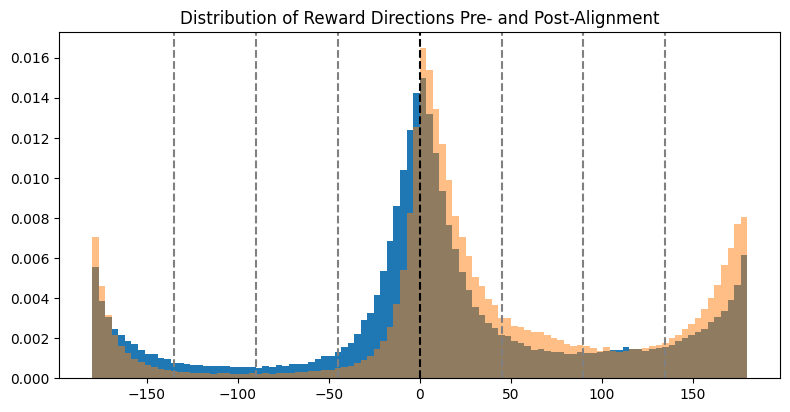

In [58]:
# Plot reward directions pre- and post-alignment

plt.figure(figsize=(8, 4))
plt.hist(angle_old, bins = 100, density=True)
plt.hist(angle_new, bins = 100, alpha=0.5, density=True)
plt.axvline(-45, color='grey', linestyle='--')
plt.axvline(45, color='grey', linestyle='--')
plt.axvline(-90, color='grey', linestyle='--')
plt.axvline(90, color='grey', linestyle='--')
plt.axvline(-135, color='grey', linestyle='--')
plt.axvline(135, color='grey', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.grid(False)
plt.tight_layout()
plt.title("Distribution of Reward Directions Pre- and Post-Alignment")
plt.savefig(f'{label}angle-flathiste.png', bbox_inches='tight', transparent=True) 

[-0.1265089  -0.01375247 -0.78651751 ...  0.32436149  2.54884225
 -2.97655021] 16
[ 0.32760468 -0.04432269  0.57146205 ...  2.20798329  1.59865222
 -3.10423137] 16
[ 0.45411357 -0.03057021  1.35797956 ...  1.8836218  -0.95019003
 -0.12768116] 16


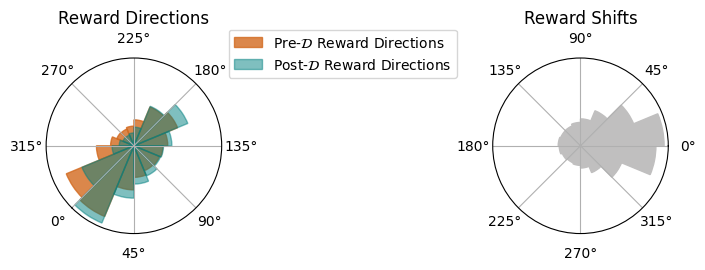

In [59]:
# Distribution of reward directions and reward shifts (see Figure 2)

angles0 = np.array([math.radians(k) for k in angle_old])
angles0 = angles0[~np.isnan(angles0)]

angles1 = np.array([math.radians(k) for k in angle_new])
angles1 = angles1[~np.isnan(angles1)]

anglesuv = np.array([math.radians(k) for k in angles])
anglesuv = anglesuv[~np.isnan(anglesuv)]

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(7,3))

line1 = circular_hist(ax[0], angles0, 0.8, r"Pre-$\mathcal{D}$ Reward Directions", offset = 5*np.pi/4, color = "chocolate")[2]
line2 = circular_hist(ax[0], angles1, 0.5, "Post-$\mathcal{D}$ Reward Directions", offset = 5*np.pi/4, color = "teal")[2]
circular_hist(ax[1], anglesuv, 1, "Alignment Relative Angles", offset = 0, color = "#c0bfbf")

ax[0].legend(handles=[line1, line2], bbox_to_anchor=(1,1.025), loc="center left")
ax[0].set_title("Reward Directions")
ax[1].set_title("Reward Shifts")
plt.tight_layout()
plt.savefig(f'{label}angle-round.png', bbox_inches='tight', transparent=True) 

[ 0.45411357 -0.03057021  1.35797956 ...  1.8836218  -0.95019003
 -0.12768116] 16


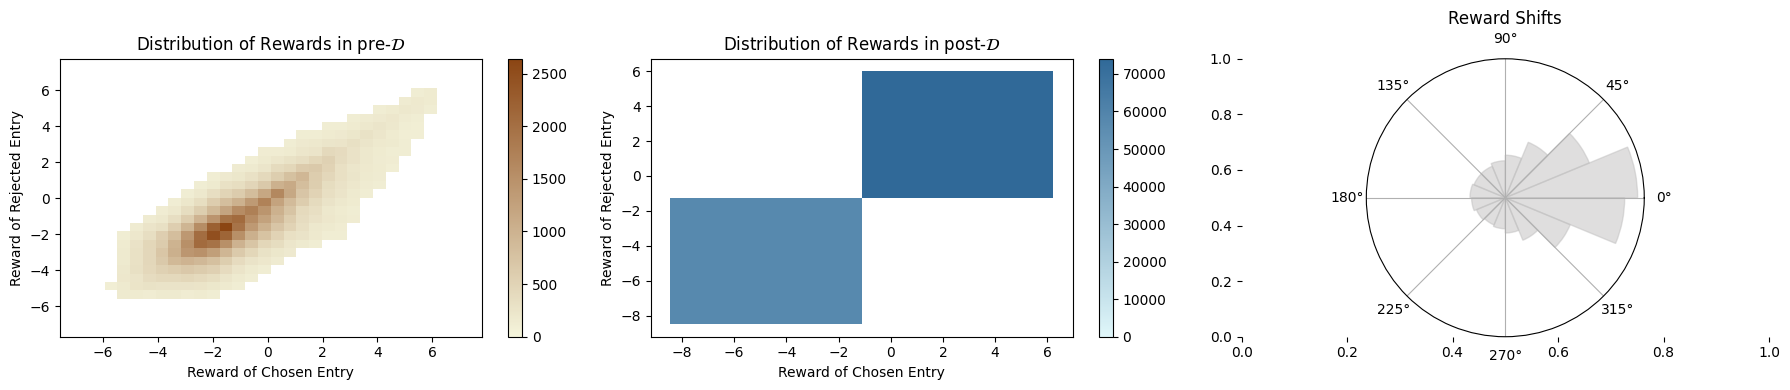

In [61]:
# Distribution of reward vectors and reward shifts (see Figure 2)

angles0 = np.array([math.radians(k) for k in angle_old])
angles0 = angles0[~np.isnan(angles0)]

angles1 = np.array([math.radians(k) for k in angle_new])
angles1 = angles1[~np.isnan(angles1)]

anglesuv = np.array([math.radians(k) for k in angles])
anglesuv = anglesuv[~np.isnan(anglesuv)]

heatmap_data_current, xedges, yedges = np.histogram2d(
    df_rewards["chosen_score"], 
    df_rewards["rejected_score"], 
    bins=30, 
    range=[[df_rewards["chosen_score"].min(), df_rewards["chosen_score"].max()], 
           [df_rewards["rejected_score"].min(), df_rewards["rejected_score"].max()]]
)
heatmap_data_n_1, _, _ = np.histogram2d(
    df_rewards_n_1["chosen_score"], 
    df_rewards_n_1["rejected_score"], 
    bins=30, 
    range=[[df_rewards_n_1["chosen_score"].min(), df_rewards_n_1["chosen_score"].max()], 
           [df_rewards_n_1["rejected_score"].min(), df_rewards_n_1["rejected_score"].max()]]
)
heatmap_df_current = pd.DataFrame(heatmap_data_current, index=yedges[:-1], columns=xedges[:-1])
heatmap_df_n_1 = pd.DataFrame(heatmap_data_n_1, index=yedges[:-1], columns=xedges[:-1])

num_ticks = 5
x_ticks = np.linspace(xedges[0], xedges[-1], num=num_ticks)
y_ticks = np.linspace(yedges[0], yedges[-1], num=num_ticks)
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
python_teal = "#306998"  # This is teal

teal_cmap = mcolors.LinearSegmentedColormap.from_list("Teal", ["#e0f7fa", python_teal])

sns.histplot(
    data=df_rewards,
    x='chosen_score',
    y='rejected_score',
    bins=(2, 2),
    pthresh=0.1,
    cmap=teal_cmap, ax=ax[1], cbar=True
)
ax[1].set_title(r"Distribution of Rewards in post-$\mathcal{D}$")
ax[1].set_xlabel('Reward of Chosen Entry')
ax[1].set_ylabel('Reward of Rejected Entry')

brown_color = "#8B4513"  # This is brown

brown_cmap = mcolors.LinearSegmentedColormap.from_list("Brown", ["#f5f5dc", brown_color])

sns.histplot(
    data=df_rewards_n_1,
    x='chosen_score',
    y='rejected_score',
    bins=(30, 30),
    pthresh=0.1,
    cmap=brown_cmap, ax=ax[0], cbar=True
)
ax[0].set_title(r"Distribution of Rewards in pre-$\mathcal{D}$")
ax[0].set_xlabel('Reward of Chosen Entry')
ax[0].set_ylabel('Reward of Rejected Entry')
ax[2].set_frame_on(False)
ax[2] = plt.subplot(133, projection='polar')
line2 = circular_hist(ax[2], anglesuv, 0.5, "Alignment Relative Angles", offset=0, color="#c0bfbf")
ax[2].set_title("Reward Shifts")


plt.tight_layout()
plt.savefig(f'angle-round.png', bbox_inches='tight', transparent=True)
plt.show()


[-1.26508897e-01 -7.86517512e-01 -2.69324614e+00 ... -6.17932006e-01
 -2.74219387e+00 -7.30681480e-04] 16
[-0.01375247 -0.2365539  -1.4930822  ... -0.09905334 -2.79325351
 -2.97655021] 16
[2.78239992e-03 2.74488700e-01 3.12817638e-01 ... 2.87241430e-01
 3.06032118e+00 4.72112234e-02] 16
[0.02179367 0.0437077  0.15360092 ... 2.18693726 0.32436149 2.54884225] 16
[0.32760468 0.57146205 0.13331924 ... 2.60826294 0.13917655 0.39791454] 16
[-0.04432269 -0.33420947 -0.60095831 ... -2.08194383 -2.96061092
 -3.10423137] 16
[-0.06203417 -0.03701749 -0.21076419 ... -0.21531847 -3.08086587
 -0.16057135] 16
[0.16262488 0.076351   0.70281917 ... 2.15085418 2.20798329 1.59865222] 16


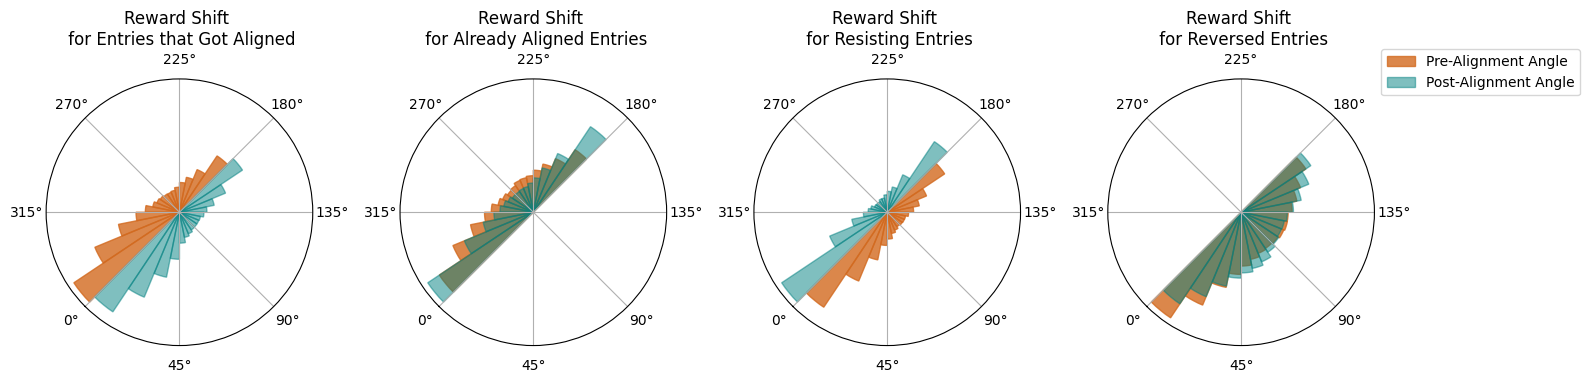

In [63]:

# Reward directions per alignment regime

angles11 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")].angles_u])
angles11 = angles11[~np.isnan(angles11)]

angles11u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")].angles_u])
angles11u = angles11u[~np.isnan(angles11u)]

angles12 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")].angles_u])
angles12 = angles12[~np.isnan(angles12)]

angles14 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")].angles_u])
angles14 = angles14[~np.isnan(angles14)]

qangles11 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")].angles_v])
qangles11 = qangles11[~np.isnan(qangles11)]

qangles11u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")].angles_v])
qangles11u = qangles11u[~np.isnan(qangles11u)]

qangles12 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")].angles_v])
qangles12 = qangles12[~np.isnan(qangles12)]


qangles14 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")].angles_v])
qangles14 = qangles14[~np.isnan(qangles14)]

fig, ax = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(16, 8))

l1 = circular_hist(ax[0], angles11, 0.8, "Pre-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "chocolate")[2]
l2 = circular_hist(ax[1], angles11u, 0.8, "Pre-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "chocolate")[2]
l3 = circular_hist(ax[2], angles12, 0.8, "Pre-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "chocolate")[2]
l4 = circular_hist(ax[3], angles14, 0.8, "Pre-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "chocolate")[2]

l5 = circular_hist(ax[0], qangles11, 0.5, "Post-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "teal")[2]
l6 = circular_hist(ax[1], qangles11u, 0.5, "Post-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "teal")[2]
l7 = circular_hist(ax[2], qangles12, 0.5, "Post-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "teal")[2]
l8 = circular_hist(ax[3], qangles14, 0.5, "Post-Alignment Angle", bins=16, offset = 5*np.pi/4, color = "teal")[2]

ax[3].legend(handles=[l4, l8], bbox_to_anchor=(1,1.025), loc="center left")

ax[0].set_title("Reward Shift \n for Entries that Got Aligned")
ax[2].set_title("Reward Shift \n for Resisting Entries")
ax[3].set_title("Reward Shift \n for Reversed Entries")
ax[1].set_title("Reward Shift \n for Already Aligned Entries")

plt.tight_layout()
plt.legend()
plt.legend(bbox_to_anchor=(1,1.025), loc="center left")
plt.savefig(f'{label}angle-round-per-ai-absolute.png', bbox_inches='tight', transparent=True) 


## RLHF does not impact rewards direction much

[-0.04432269  0.16262488 -0.33420947 ...  0.39791454  2.20798329
 -3.10423137] 16
[-0.1265089  -0.78651751 -2.69324614 ...  0.46376199  1.86875775
  2.54884225] 16
[ 0.65536634 -0.06203417  0.15869992 ...  1.1397591  -0.12428147
 -0.21531847] 16
[-1.37524743e-02  2.17936672e-02 -2.36553903e-01 ... -7.30681480e-04
  3.24361487e-01 -2.97655021e+00] 16
[0.32760468 0.57146205 0.13331924 ... 2.52812732 2.66695501 1.59865222] 16
[-0.8294139   0.0027824  -0.34259617 ...  0.62089094 -0.39549313
  0.28724143] 16


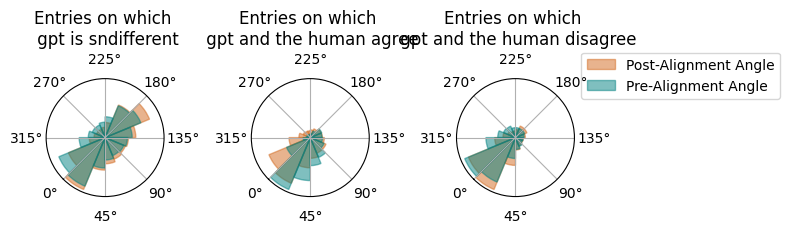

In [64]:
# Reward directions per \gamma_i regime

angles11 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 0)].angles_v])
angles11 = angles11[~np.isnan(angles11)]

angles11u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 0)].angles_u])
angles11u = angles11u[~np.isnan(angles11u)]

angles12 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 'c')].angles_v])
angles12 = angles12[~np.isnan(angles12)]

angles12u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 'c')].angles_u])
angles12u = angles12u[~np.isnan(angles12u)]

angles14 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 'r')].angles_v])
angles14 = angles14[~np.isnan(angles14)]

angles14u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 'r')].angles_u])
angles14u = angles14u[~np.isnan(angles14u)]

fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(8, 4))
line1 = circular_hist(ax[0], angles11, 0.5, "Post-Alignment Angle", offset = 5*np.pi/4, color = "chocolate")[2]
line4 = circular_hist(ax[1], angles12u, 0.5, "Pre-Alignment Angle", offset = 5*np.pi/4, color = "chocolate")[2]
line5 = circular_hist(ax[2], angles14, 0.5, "Post-Alignment Angle", offset = 5*np.pi/4, color = "chocolate")[2]

line2 = circular_hist(ax[0], angles11u, 0.5, "Pre-Alignment Angle", offset = 5*np.pi/4, color = "teal")[2]
line3 = circular_hist(ax[1], angles12, 0.5, "Post-Alignment Angle", offset = 5*np.pi/4, color = "teal")[2]
line6 = circular_hist(ax[2], angles14u, 0.5, "Pre-Alignment Angle", offset = 5*np.pi/4, color = "teal")[2]
ax[0].set_title("Entries on which \n gpt is sndifferent")
ax[1].set_title("Entries on which \n gpt and the human agree")

ax[2].legend(handles=[line1, line2], bbox_to_anchor=(1,1.025), loc="center left")
ax[2].set_title("Entries on which \n gpt and the human disagree")

plt.tight_layout()
plt.legend()
plt.legend(bbox_to_anchor=(1,1.025), loc="center left")
plt.savefig(f'{label}angle-round-per-gpt.png', bbox_inches='tight', transparent=True) 


[-0.03057021  0.14083121 -0.09765557 ...  0.39864522  1.8836218
 -0.12768116] 16
[ 1.48478024 -0.06481657  0.5012961  ...  0.51886816  0.27121165
 -0.5025599 ] 16
[ 0.45411357  1.35797956  2.82656538 ...  2.06436533  0.79819725
 -0.95019003] 16


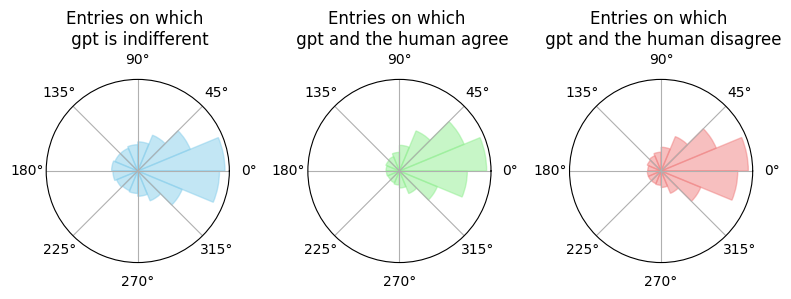

In [65]:
# Reward shifts per \gamma_i regime

angles11 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 0)].angles_uv])
angles11 = angles11[~np.isnan(angles11)]

angles12 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 'c')].angles_uv])
angles12 = angles12[~np.isnan(angles12)]

angles14 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.gpt == 'r')].angles_uv])
angles14 = angles14[~np.isnan(angles14)]

fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(8, 4))
line1 = circular_hist(ax[0], angles11, 0.5, "Post-Alignment Angle", offset = 0, color = "skyblue")[2]
line5 = circular_hist(ax[2], angles14, 0.5, "Post-Alignment Angle", offset = 0, color = "lightcoral")[2]
line3 = circular_hist(ax[1], angles12, 0.5, "Post-Alignment Angle", offset = 0, color = "lightgreen")[2]

ax[0].set_title("Entries on which \n gpt is indifferent")
ax[1].set_title("Entries on which \n gpt and the human agree")
ax[2].set_title("Entries on which \n gpt and the human disagree")

plt.tight_layout()
plt.savefig(f'{label}angle-round-rel-per-gpt.png', bbox_inches='tight', transparent=True) 


In [66]:
v1 = df_rewards.loc[(df_rewards.gpt == 0)].angles_uv
v2 = df_rewards.loc[(df_rewards.gpt == "c")].angles_uv
v3 = df_rewards.loc[(df_rewards.gpt == "r")].angles_uv

t_statistic, p_value = sign_test(v1, 0)
print("gpt indifferent", t_statistic, p_value, np.nanmedian(v1), np.mean(v1))

t_statistic, p_value = sign_test(v2, 0)
print("gpt agrees", t_statistic, p_value, np.median(v2), np.mean(v2))

t_statistic, p_value = sign_test(v3, 0)
print("gpt disagrees", t_statistic, p_value, np.median(v3), np.mean(v3))

gpt indifferent 6345.0 2.482061628535231e-292 3.3029048341346807 5.18713687196345
gpt agrees 4880.0 0.0 11.630167091521232 11.580122381522841
gpt disagrees 1109.5 3.576676488991093e-103 nan 7.451219482490403


In [69]:
# Proportion of reward vectors per quadrant post-D

l1 = len(df_rewards.loc[(df_rewards.chosen_score > 0)&(df_rewards.rejected_score> 0)])
l2 = len(df_rewards.loc[(df_rewards.chosen_score < 0)&(df_rewards.rejected_score> 0)])
l3 = len(df_rewards.loc[(df_rewards.chosen_score > 0)&(df_rewards.rejected_score< 0)])
l1/len(df_rewards), l2/len(df_rewards), l3/len(df_rewards), len(df_rewards.loc[(df_rewards.chosen_score < 0)&(df_rewards.rejected_score< 0)])/len(df_rewards)

(0.280068407960199,
 0.025833333333333333,
 0.16659203980099502,
 0.5275062189054727)

In [70]:
# Proportion of reward vectors per quadrant pre-D

l1 = len(df_rewards_n_1.loc[(df_rewards_n_1.chosen_score > 0)&(df_rewards_n_1.rejected_score> 0)])
l2 = len(df_rewards_n_1.loc[(df_rewards_n_1.chosen_score < 0)&(df_rewards_n_1.rejected_score> 0)])
l3 = len(df_rewards_n_1.loc[(df_rewards_n_1.chosen_score > 0)&(df_rewards_n_1.rejected_score< 0)])
l1/len(df_rewards), l2/len(df_rewards), l3/len(df_rewards), len(df_rewards_n_1.loc[(df_rewards_n_1.chosen_score < 0)&(df_rewards_n_1.rejected_score< 0)])/len(df_rewards)

(0.23121890547263682,
 0.06297885572139303,
 0.13084577114427862,
 0.5749564676616915)

In [71]:
# Statistical test on angles based on \gamma_i

v1 = df_rewards.loc[(df_rewards.align_shift == "got aligned")].angles_uv
v2 = df_rewards.loc[(df_rewards.align_shift == "resists alignment")].angles_uv
v3 = df_rewards.loc[(df_rewards.align_shift == "reversed alignment")].angles_uv
v4 = df_rewards.loc[(df_rewards.align_shift == "stayed aligned")].angles_uv

t_statistic, p_value = sign_test(df_rewards.angles_uv, 0)
print("Goal", t_statistic, p_value)
t_statistic, p_value = ttest_1samp(df_rewards.angles_uv, 0, nan_policy="omit")
print(f"t-statistic: {t_statistic}", np.mean(df_rewards.angles_uv), np.nanmedian(df_rewards.angles_uv))
print(f"P-value: {p_value}")

t_statistic, p_value = sign_test(v1, 0)
print("Goal", t_statistic, p_value)
t_statistic, p_value = ttest_1samp(v1, 0)
print(f"t-statistic: {t_statistic}", np.mean(v1), np.nanmedian(v1))
print(f"P-value: {p_value}")

t_statistic, p_value = sign_test(v2, 0)
print("Resists", t_statistic, p_value)
t_statistic, p_value = ttest_1samp(v2, 0, nan_policy="omit")
print(f"t-statistic: {t_statistic}", np.mean(v2), np.nanmedian(v2))
print(f"P-value: {p_value}")

t_statistic, p_value = sign_test(v3, 0)
print("Reversed", t_statistic, p_value)
t_statistic, p_value = ttest_1samp(v3, 0)
print(f"t-statistic: {t_statistic}", np.mean(v3), np.nanmedian(v3))
print(f"P-value: {p_value}")

t_statistic, p_value = sign_test(v4, 0)
print("Stays", t_statistic, p_value)
t_statistic, p_value = ttest_1samp(v4, 0)
print(f"t-statistic: {t_statistic}", np.mean(v4), np.nanmedian(v4))
print(f"P-value: {p_value}")

Goal 12334.5 0.0
t-statistic: 43.75101356494266 6.480243564618589 4.950758910515432
P-value: 0.0
Goal 10257.5 0.0
t-statistic: 53.74665385266138 18.00257034284661 21.43114955144701
P-value: 0.0
Resists -725.5 9.788672805542571e-19
t-statistic: -22.207889652122855 -7.779808624030266 -0.8733849812477585
P-value: 2.6835854972220213e-108
Reversed -2791.5 0.0
t-statistic: -17.05699191953281 -9.901672082354601 -12.413982226328264
P-value: 1.3821697072724757e-64
Stays 5594.0 0.0
t-statistic: 45.49186431632747 8.262554580912274 3.510766815939715
P-value: 0.0


goal 5581.5 0.0 30.706853468471085 34.19382813301045
t-statistic: 83.04812411818935
P-value: 0.0
stayed 1330.0 6.305816748151711e-82 3.142860708087382 2.38396392620568
t-statistic: 8.605984061433015
P-value: 8.137817479717209e-18
resists 413.5 2.3432729450242786e-33 nan 3.1737734228631056
t-statistic: nan
P-value: nan
reversed -1335.5 0.0 -18.44420164415927 -23.79288125244617
t-statistic: -30.145228337068122
P-value: 2.5370414330276224e-174
[ 0.45411357  1.35797956  2.82656538 ...  0.31634163  1.99395106
 -2.91865012] 16
[1.48478024 0.5012961  0.63439798 ... 1.317175   0.03297755 0.42839191] 16
[ 5.49218251e-01 -1.80585846e-01  1.20087918e-04 ...  2.06436533e+00
  7.98197252e-01 -9.50190032e-01] 16
[-0.09731929 -0.2941163  -0.26180154 ... -0.14420509  0.41691221
  0.51886816] 16
[-0.09325841  0.08194185  0.06921901 ...  0.35290126 -2.43174997
 -0.03860959] 16
[ 0.42093411 -0.07592519 -0.25077676 ... -0.33935128 -0.06391259
  0.27121165] 16
[-0.52358183 -0.53232714 -0.70130576 ...  0.98

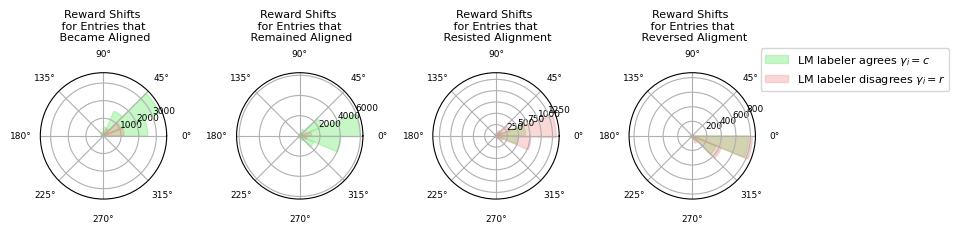

In [76]:
# Reward shifts per alignment regimes and \gamma_i for \gamma_i \in {r, c} (Figure 4)

v1 = df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt != 0)].angles_uv
t_statistic, p_value = sign_test(v1, 0)
print("goal", t_statistic, p_value, np.nanmedian(v1), np.mean(v1))
t_statistic, p_value = ttest_1samp(v1, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

v2 = df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt != 0)].angles_uv
t_statistic, p_value = sign_test(v2, 0)
print("stayed", t_statistic, p_value, np.median(v2), np.mean(v2))
t_statistic, p_value = ttest_1samp(v2, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

v3 = df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt != 0)].angles_uv
t_statistic, p_value = sign_test(v3, 0)
print("resists", t_statistic, p_value, np.median(v3), np.mean(v3))
t_statistic, p_value = ttest_1samp(v3, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

v4 = df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt != 0)].angles_uv
t_statistic, p_value = sign_test(v4, 0)
print("reversed", t_statistic, p_value, np.median(v4), np.mean(v4))
t_statistic, p_value = ttest_1samp(v4, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

angles11 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 0)].angles_uv])
angles11 = angles11[~np.isnan(angles11)]

angles11u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 'c')].angles_uv])
angles11u = angles11u[~np.isnan(angles11u)]

angles12 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 'r')].angles_uv])
angles12 = angles12[~np.isnan(angles12)]



angles11a = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 0)].angles_uv])
angles11a = angles11a[~np.isnan(angles11a)]

angles11ua = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 'c')].angles_uv])
angles11ua = angles11ua[~np.isnan(angles11ua)]

angles12a = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 'r')].angles_uv])
angles12a = angles12a[~np.isnan(angles12a)]


angles11b = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 0)].angles_uv])
angles11b = angles11b[~np.isnan(angles11b)]

angles11ub = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 'c')].angles_uv])
angles11ub = angles11ub[~np.isnan(angles11ub)]

angles12b = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 'r')].angles_uv])
angles12b = angles12b[~np.isnan(angles12b)]



angles11c = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 0)].angles_uv])
angles11c = angles11c[~np.isnan(angles11c)]

angles11uc = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 'c')].angles_uv])
angles11uc = angles11uc[~np.isnan(angles11uc)]

angles12c = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 'r')].angles_uv])
angles12c = angles12c[~np.isnan(angles12c)]

fig, ax = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(8, 4))

l2 = circular_hist(ax[0], angles11u, 0.5, r"LM labeler agrees $\gamma_i=c$", bins=16, offset = 0, color = "lightgreen", density=False)[2]
l3 = circular_hist(ax[0], angles12, 0.3, r"LM labeler disagrees $\gamma_i=r$", bins=16, offset = 0, color = "lightcoral", density=False)[2]

l2a = circular_hist(ax[1], angles11ua, 0.5, r"LM labeler agrees $\gamma_i=c$", bins=16, offset = 0, color = "lightgreen", density=False)[2]
l3a = circular_hist(ax[1], angles12a, 0.3, r"LM labeler disagrees $\gamma_i=r$", bins=16, offset = 0, color = "lightcoral", density=False)[2]

l2b = circular_hist(ax[2], angles11ub, 0.5,r"LM labeler agrees $\gamma_i=c$", bins=16, offset = 0, color = "lightgreen", density=False)[2]
l3b = circular_hist(ax[2], angles12b, 0.3, r"LM labeler disagrees $\gamma_i=r$", bins=16, offset = 0, color = "lightcoral", density=False)[2]

l2c = circular_hist(ax[3], angles11uc, 0.5, r"LM labeler agrees $\gamma_i=c$", bins=16, offset = 0, color = "lightgreen", density=False)[2]
l3c = circular_hist(ax[3], angles12c, 0.3, r"LM labeler disagrees $\gamma_i=r$", bins=16, offset = 0, color = "lightcoral", density=False)[2]


ax[0].set_title("Reward Shifts \n for Entries that \n Became Aligned", fontsize=8)
ax[2].set_title("Reward Shifts \n for Entries that \n Resisted Alignment", fontsize=8)
ax[3].set_title("Reward Shifts \n for Entries that \n Reversed Aligment", fontsize=8)
ax[1].set_title("Reward Shifts \n for Entries that \n Remained Aligned", fontsize=8)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=6.5)

plt.tight_layout()
plt.legend()
plt.legend(bbox_to_anchor=(1,1.025), loc="center left", fontsize=8)
plt.savefig(f'{label}angle-round-per-ai-absolute-gpt1.png', bbox_inches='tight', transparent=True) 


goal 4676.0 0.0 15.752408925282559 11.176517331290608 15.752408925282559
t-statistic: 25.559031439053854
P-value: 1.6219719103660955e-142
stayed 4264.0 6.251707194046558e-274 3.6485244764525913 10.206569752689795 3.6485244764525913
t-statistic: 45.7540601590109
P-value: 0.0
resists -1139.0 8.092150993730965e-53 nan -10.106198353349383 -1.8979745032907793
t-statistic: -25.092385794049974
P-value: 4.792139170944777e-137
reversed -1456.0 6.678154429079871e-170 -9.85150763278303 -6.200601675880537 -9.85150763278303
t-statistic: -8.854274940084427
P-value: 9.700496407010871e-19
Goal 4676.0 0.0
Resists 4264.0 6.251707194046558e-274
Reversed -1139.0 8.092150993730965e-53
Stays -1456.0 6.678154429079871e-170
[ 0.33147563  0.39499463  0.27046793 ... -3.05699036  2.88137042
  0.39864522] 16
[ 0.14083121  0.0326433  -0.00945603 ... -0.78101052 -0.03608308
  1.8836218 ] 16
[-0.03057021 -0.09765557  0.89212389 ... -1.98289049 -0.16735742
 -0.12768116] 16
[-0.31150619 -0.1765879  -0.32330532 ...  0.

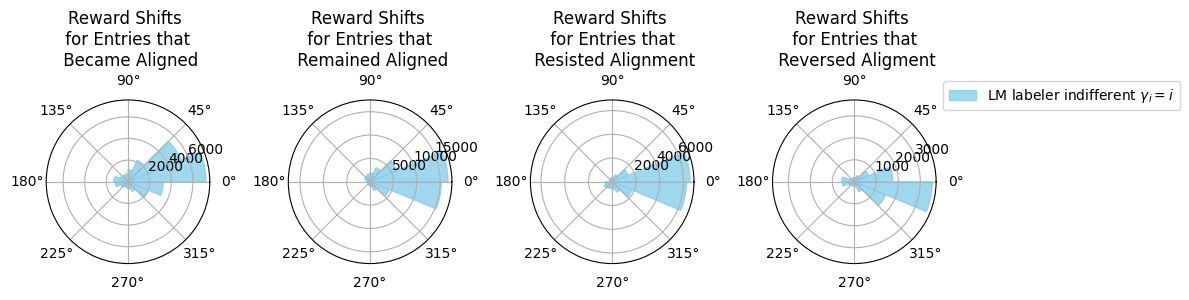

In [99]:
# Adding \gamma_i = i (Figure 18)

v1 = df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 0)].angles_uv
t_statistic, p_value = sign_test(v1, 0)
print("goal", t_statistic, p_value, np.nanmedian(v1), np.mean(v1), np.median(v1))
t_statistic, p_value = ttest_1samp(v1, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

v2 = df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 0)].angles_uv
t_statistic, p_value = sign_test(v2, 0)
print("stayed", t_statistic, p_value, np.median(v2), np.mean(v2), np.nanmedian(v2))
t_statistic, p_value = ttest_1samp(v2, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

v3 = df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 0)].angles_uv
t_statistic, p_value = sign_test(v3, 0)
print("resists", t_statistic, p_value, np.median(v3), np.mean(v3), np.nanmedian(v3))
t_statistic, p_value = ttest_1samp(v3, 0, nan_policy="omit")
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

v4 = df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 0)].angles_uv
t_statistic, p_value = sign_test(v4, 0)
print("reversed", t_statistic, p_value, np.median(v4), np.mean(v4), np.median(v4))
t_statistic, p_value = ttest_1samp(v4, 0)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t_statistic, p_value = sign_test(df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 0)].angles_uv, 0)
print("Goal", t_statistic, p_value)

t_statistic, p_value = sign_test(df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 0)].angles_uv, 0)
print("Resists", t_statistic, p_value)

t_statistic, p_value = sign_test(df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 0)].angles_uv, 0)
print("Reversed", t_statistic, p_value)

t_statistic, p_value = sign_test(df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 0)].angles_uv, 0)
print("Stays", t_statistic, p_value)

angles11 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 0)].angles_uv])
angles11 = angles11[~np.isnan(angles11)]

angles11u = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 'c')].angles_uv])
angles11u = angles11u[~np.isnan(angles11u)]

angles12 = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "got aligned")&(df_rewards.gpt == 'r')].angles_uv])
angles12 = angles12[~np.isnan(angles12)]



angles11a = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 0)].angles_uv])
angles11a = angles11a[~np.isnan(angles11a)]

angles11ua = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 'c')].angles_uv])
angles11ua = angles11ua[~np.isnan(angles11ua)]

angles12a = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "stayed aligned")&(df_rewards.gpt == 'r')].angles_uv])
angles12a = angles12a[~np.isnan(angles12a)]


angles11b = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 0)].angles_uv])
angles11b = angles11b[~np.isnan(angles11b)]

angles11ub = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 'c')].angles_uv])
angles11ub = angles11ub[~np.isnan(angles11ub)]

angles12b = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "resists alignment")&(df_rewards.gpt == 'r')].angles_uv])
angles12b = angles12b[~np.isnan(angles12b)]



angles11c = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 0)].angles_uv])
angles11c = angles11c[~np.isnan(angles11c)]

angles11uc = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 'c')].angles_uv])
angles11uc = angles11uc[~np.isnan(angles11uc)]

angles12c = np.array([math.radians(k) for k in df_rewards.loc[(df_rewards.align_shift == "reversed alignment")&(df_rewards.gpt == 'r')].angles_uv])
angles12c = angles12c[~np.isnan(angles12c)]

fig, ax = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(12, 8))

l1 = circular_hist(ax[0], angles11, 0.8, r"LM labeler indifferent $\gamma_i=i$", bins=16, offset = 0, color = "skyblue", density=False)[2]

l1a = circular_hist(ax[1], angles11a, 0.8, r"LM labeler indifferent $\gamma_i=i$", bins=16, offset = 0, color = "skyblue", density=False)[2]

l1b = circular_hist(ax[2], angles11b, 0.8, r"LM labeler indifferent $\gamma_i=i$", bins=16, offset = 0, color = "skyblue", density=False)[2]

l1c = circular_hist(ax[3], angles11c, 0.8, r"LM labeler indifferent $\gamma_i=i$", bins=16, offset = 0, color = "skyblue", density=False)[2]

ax[3].legend(handles=[l1, l1c], bbox_to_anchor=(1,1.025), loc="center left")
ax[0].set_title("Reward Shifts \n for Entries that \n Became Aligned")
ax[2].set_title("Reward Shifts \n for Entries that \n Resisted Alignment")
ax[3].set_title("Reward Shifts \n for Entries that \n Reversed Aligment")
ax[1].set_title("Reward Shifts \n for Entries that \n Remained Aligned")

plt.tight_layout()
plt.legend()
plt.legend(bbox_to_anchor=(1,1.025), loc="center left")
plt.savefig(f'{label}angle-round-per-ai-absolute-gpt-ind.png', bbox_inches='tight', transparent=True) 


## What was learned by the model? Code for regression plots

In [ ]:
def plot_est_all(ax, estimates, std_errors, p_values, variables, col):
    x_pos = np.arange(len(variables))

    colors = []
    ki = 0
    ind_ki = []
    alpha = []
    for p_value in p_values:
        if p_value < 0.05:
            colors.append(col)
            alpha.append(1)
        else:
            colors.append(col)
            alpha.append(0.4)
    for i, (estimate, std_error, color, a) in enumerate(zip(estimates, std_errors, colors, alpha)):
        ax.errorbar(x_pos[i], estimate, yerr=std_error, fmt='o', capsize=5, color=color, alpha=a)
    plot = ax.scatter(x_pos, estimates, c=colors, alpha=alpha)
    
    return plot


In [ ]:
chosen_df = df[df['preference'] == 'chosen'].drop(columns=["preference", "text", "last_response_is_discriminating_against", "topics"])
rejected_df = df[df['preference'] == 'rejected'].drop(columns=["preference", "text", "last_response_is_discriminating_against", "topics"])

d_flat = pd.merge(chosen_df, rejected_df, on='row_id')
ddd_u = pd.merge(d_flat, df_rewards[["row_id", "cos_u", "align_shift", "cos_v", "angles_uv"]], how="left", on="row_id")

ddd_u.to_csv("output/2024-07-10-angles-old-new.csv")


In [ ]:
ddd_u.head()

,row_id,assistant_is_anthropomorphic_x,assistant_is_coherent_x,human_vocabulary_quality_x,last_response_is_anthropomorphic_x,last_response_is_coherent_x,last_response_is_refusal_x,last_response_is_helpful_x,last_response_is_harmless_x,last_response_is_honest_x,...,last_response_is_sexually_explicit_y,last_response_breaks_privacy_y,last_response_is_discriminatory_y,last_response_is_manipulative_y,last_response_is_creative_y,last_response_is_eloquent_y,cos_u,align_shift,cos_v,angles_uv
0,0,0,1,0,0,1,0,0,1,1,...,0,0,1,0,0,0,-0.126172,got aligned,0.321776,26.018791
1,1,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,-0.013752,resists alignment,-0.044308,-1.751544
2,2,0,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,-0.707898,got aligned,0.540862,77.806498
3,3,0,0,1,0,1,1,0,1,1,...,0,1,0,0,0,0,-0.433476,got aligned,0.132925,161.950267
4,4,0,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,-0.737536,got aligned,0.609450,85.071641


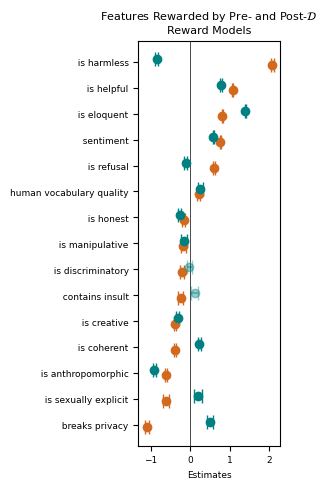

In [78]:
# Regression 1 Figure 3 (left)

def plot_est(ax, estimates1, estimates2, std_errors1, std_errors2, p_values1, p_values2, variables, offset=0.1):
    y_pos = np.arange(len(variables))
    colors1 = []
    colors2 = []
    alpha1 = []
    alpha2 = []
    
    for p_value in p_values2:
        if p_value < 0.05:
            colors2.append('teal')
            alpha2.append(1)
        else:
            colors2.append('teal')
            alpha2.append(0.4)
            
    for p_value in p_values1:
        if p_value < 0.05:
            colors1.append('chocolate')
            alpha1.append(1)
        else:
            colors1.append('chocolate')
            alpha1.append(0.4)
    
    for i, (estimate, std_error, color, a) in enumerate(zip(estimates1, std_errors1, colors1, alpha1)):
        ax.errorbar(estimate, y_pos[i] - offset, xerr=std_error, fmt='o', capsize=5, color=color, alpha=a)
    for i, (estimate, std_error, color, a) in enumerate(zip(estimates2, std_errors2, colors2, alpha2)):
        ax.errorbar(estimate, y_pos[i] + offset, xerr=std_error, fmt='o', capsize=5, color=color, alpha=a)
        
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)

fig, ax = plt.subplots(figsize=(3, 5))
plot_est(ax, estimates1, estimates2, std_errors1, std_errors2, p_values1, p_values2, variables)
ax.axvline(0, color='black', linewidth=0.5) 
ax.set_xlabel('Estimates', fontsize=6.5)
ax.set_title('Features Rewarded by Pre- and Post-$\mathcal{D}$\nReward Models', fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=6.5)
plt.tight_layout()
plt.savefig('merged_plot2.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

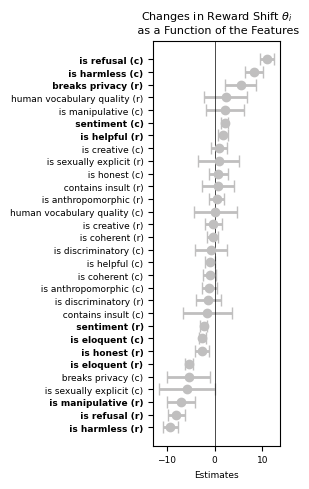

In [79]:
# Regression 2 Figure 3 (center)

estimates = [
    0.19211, -1.05953, -1.04764, 10.91525, -0.86119, 8.24882, 0.81146, 
    2.16623, -1.48596, -5.70818, -5.40997, -0.73003, 2.17074, 0.91934, -2.53064, 
    2.29442, 0.48927, -0.35782, -7.93692, 1.78618, -9.21136, -2.55246, -2.22267, 
    0.73784, 0.84001, 5.44889, -1.30329, -6.97529, -0.27606, -5.40440
]

std_errors = [
    2.24897, 0.82726, 0.64807, 0.76758, 0.52211, 0.96681, 0.96707, 
    0.35899, 2.58849, 2.93893, 2.20115, 1.68584, 1.98345, 0.84508, 0.40271, 
    2.26386, 0.77168, 0.56979, 0.92410, 0.49831, 0.79467, 0.74986, 0.36968, 
    1.70057, 2.12900, 1.63167, 1.31072, 1.48322, 0.88523, 0.42642
]

p_values = [
    1.00000, 1.00000, 1.00000, 0.00000, 1.00000, 0.00000, 1.00000, 
    0.00000, 1.00000, 1.00000, 0.43339, 1.00000, 1.00000, 1.00000, 0.00000, 
    1.00000, 1.00000, 1.00000, 0.00000, 0.01047, 0.00000, 0.02060, 0.00000, 
    1.00000, 1.00000, 0.02603, 1.00000, 0.00008, 1.00000, 0.00000
]

variables = [
    'human_vocabulary_quality_x', 'last_response_is_anthropomorphic_x', 
    'last_response_is_coherent_x', 'last_response_is_refusal_x', 'last_response_is_helpful_x', 
    'last_response_is_harmless_x', 'last_response_is_honest_x', 'last_response_sentiment_x', 
    'last_response_contains_insult_x', 'last_response_is_sexually_explicit_x', 
    'last_response_breaks_privacy_x', 'last_response_is_discriminatory_x', 
    'last_response_is_manipulative_x', 'last_response_is_creative_x', 'last_response_is_eloquent_x', 
    'human_vocabulary_quality_y', 'last_response_is_anthropomorphic_y', 'last_response_is_coherent_y', 
    'last_response_is_refusal_y', 'last_response_is_helpful_y', 'last_response_is_harmless_y', 
    'last_response_is_honest_y', 'last_response_sentiment_y', 'last_response_contains_insult_y', 
    'last_response_is_sexually_explicit_y', 'last_response_breaks_privacy_y', 
    'last_response_is_discriminatory_y', 'last_response_is_manipulative_y', 
    'last_response_is_creative_y', 'last_response_is_eloquent_y'
]

sorted_indices = np.argsort(estimates)
estimates = np.array(estimates)[sorted_indices]
std_errors = np.array(std_errors)[sorted_indices]
p_values = np.array(p_values)[sorted_indices]
variables = np.array(variables)[sorted_indices]
std_errors = [2*k for k in std_errors]
variables = [" ".join(v.split("last_response")) for v in variables]

x_pos = np.arange(len(variables))


fig, ax = plt.subplots(figsize=(3, 5))
ax.errorbar(estimates, x_pos, xerr=std_errors, fmt='o', color='#c0bfbf', ecolor='#c0bfbf', elinewidth=2, capsize=4)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels([label.replace('_x', ' (c)').replace('_y', ' (r)').replace('_', ' ') for label in variables])
ax.set_xlabel('Estimates', fontsize=6.5)
ax.set_title('Changes in Reward Shift $\\theta_i$ \n as a Function of the Features', fontsize=8)
for ki, p_value in enumerate(p_values):
    if p_value < 0.05:
        label = ax.get_yticklabels()[ki]
        label.set_fontweight('bold')
ax.tick_params(axis='both', which='major', labelsize=6.5)

plt.tight_layout()
label = "Plots_full"
plt.savefig('theta2.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

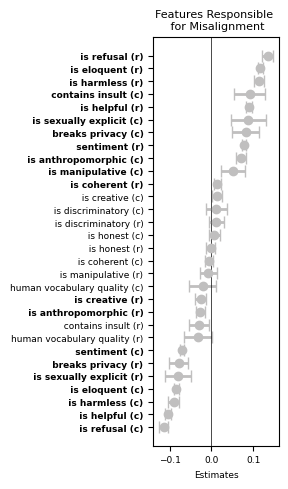

In [81]:
# Regression 3 Figure 3 (right)

estimates = [
    -0.0208986, 0.0701193, -0.0058469, -0.1147076, -0.1047052, -0.0906475, 
    0.0070138, -0.0696507, 0.0923650, 0.0880678, 0.0817138, 0.0121318, 
    0.0519026, 0.0123719, -0.0841168, -0.0322514, -0.0267907, 0.0136881, 
    0.1345951, 0.0900297, 0.1141095, -0.0010480, 0.0776411, -0.0290718, 
    -0.0805788, -0.0784834, 0.0118938, -0.0071886, -0.0260757, 0.1166361
]

std_errors = [
    0.0161260, 0.0059318, 0.0046469, 0.0055038, 0.0037438, 0.0069324, 
    0.0069343, 0.0025741, 0.0185605, 0.0210733, 0.0157831, 0.0120881, 
    0.0142221, 0.0060596, 0.0028876, 0.0162328, 0.0055332, 0.0040856, 
    0.0066261, 0.0035731, 0.0056981, 0.0053768, 0.0026507, 0.0121938, 
    0.0152657, 0.0116997, 0.0093984, 0.0106352, 0.0063475, 0.0030576
]

p_values = [
    1.0, 2.2e-16, 1.0, 2.2e-16, 2.2e-16, 2.2e-16, 
    1.0, 2.2e-16, 2.008e-05, 0.0009072, 6.979e-06, 1.0, 
    0.0081476, 1.0, 2.2e-16, 1.0, 3.989e-05, 0.0250258, 
    2.2e-16, 2.2e-16, 2.2e-16, 1.0, 2.2e-16, 0.5306729, 
    4.040e-06, 6.109e-10, 1.0, 1.0, 0.0012370, 2.2e-16
]

variables = [
    'human_vocabulary_quality_x', 'last_response_is_anthropomorphic_x', 
    'last_response_is_coherent_x', 'last_response_is_refusal_x', 
    'last_response_is_helpful_x', 'last_response_is_harmless_x', 
    'last_response_is_honest_x', 'last_response_sentiment_x', 
    'last_response_contains_insult_x', 'last_response_is_sexually_explicit_x', 
    'last_response_breaks_privacy_x', 'last_response_is_discriminatory_x', 
    'last_response_is_manipulative_x', 'last_response_is_creative_x', 
    'last_response_is_eloquent_x', 'human_vocabulary_quality_y', 
    'last_response_is_anthropomorphic_y', 'last_response_is_coherent_y', 
    'last_response_is_refusal_y', 'last_response_is_helpful_y', 
    'last_response_is_harmless_y', 'last_response_is_honest_y', 
    'last_response_sentiment_y', 'last_response_contains_insult_y', 
    'last_response_is_sexually_explicit_y', 'last_response_breaks_privacy_y', 
    'last_response_is_discriminatory_y', 'last_response_is_manipulative_y', 
    'last_response_is_creative_y', 'last_response_is_eloquent_y'
]

sorted_indices = np.argsort(estimates)
estimates = np.array(estimates)[sorted_indices]
std_errors = np.array([2*k for k in std_errors])[sorted_indices]
p_values = np.array(p_values)[sorted_indices]
variables = np.array(variables)[sorted_indices]

variables = [" ".join(v.split("last_response")) for v in variables]

x_pos = np.arange(len(variables))

fig, ax = plt.subplots(figsize=(3, 5))
ax.errorbar(estimates, x_pos, xerr=std_errors, fmt='o', color='#c0bfbf', ecolor='#c0bfbf', elinewidth=2, capsize=4)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels([label.replace('_x', ' (c)').replace('_y', ' (r)').replace('_', ' ') for label in variables])
ax.set_xlabel('Estimates', fontsize=6.5)
ax.set_title('Features Responsible \n for Misalignment', fontsize=8)
for ki, p_value in enumerate(p_values):
    if p_value < 0.05:
        label = ax.get_yticklabels()[ki]
        label.set_fontweight('bold')

ax.tick_params(axis='both', which='major', labelsize=6.5)

plt.tight_layout()
label = "Plots_full"
plt.savefig('theta_12.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

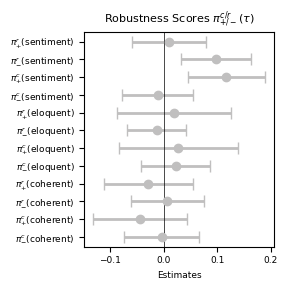

In [80]:
# Regression 4 Figure 5

data = [
    ['flip_coherent_chosen-1', -0.0037198, 0.0351339, -0.1059, 0.915682],
    ['flip_coherent_chosen1', -0.0445428, 0.0440553, -1.0111, 0.311985],
    ['flip_coherent_rejected-1', 0.0059984, 0.0341239, 0.1758, 0.860464],
    ['flip_coherent_rejected1', -0.0289716, 0.0416499, -0.6956, 0.486681],
    ['flip_eloquent_chosen-1', 0.0219833, 0.0320550, 0.6858, 0.492840],
    ['flip_eloquent_chosen1', 0.0271622, 0.0555919, 0.4886, 0.625125],
    ['flip_eloquent_rejected-1', -0.0133509, 0.0276765, -0.4824, 0.629528],
    ['flip_eloquent_rejected1', 0.0183889, 0.0533661, 0.3446, 0.730410],
    ['flip_sentiment_chosen-1', -0.0117169, 0.0330218, -0.3548, 0.722723],
    ['flip_sentiment_chosen1', 0.1169116, 0.0362538, 3.2248, 0.001261],
    ['flip_sentiment_rejected-1', 0.0979206, 0.0327228, 2.9924, 0.002768],
    ['flip_sentiment_rejected1', 0.0093179, 0.0346603, 0.2688, 0.788057]
]

variables = [row[0] for row in data]
estimates = [row[1] for row in data]
std_errors = [row[2] for row in data]
p_values = [row[4] for row in data]
std_errors = [2*k for k in std_errors]

labels_map = {
    'flip_sentiment_rejected1': r'$\pi_{+}^r(\text{sentiment})$',
    'flip_sentiment_rejected-1': r'$\pi_{-}^r(\text{sentiment})$',
    'flip_sentiment_chosen1': r'$\pi_{+}^c(\text{sentiment})$',
    'flip_sentiment_chosen-1': r'$\pi_{-}^c(\text{sentiment})$',
    'flip_coherent_rejected1': r'$\pi_{+}^r(\text{coherent})$',
    'flip_coherent_rejected-1': r'$\pi_{-}^r(\text{coherent})$',
    'flip_coherent_chosen1': r'$\pi_{+}^c(\text{coherent})$',
    'flip_coherent_chosen-1': r'$\pi_{-}^c(\text{coherent})$',
    'flip_eloquent_rejected1': r'$\pi_{+}^r(\text{eloquent})$',
    'flip_eloquent_rejected-1': r'$\pi_{-}^r(\text{eloquent})$',
    'flip_eloquent_chosen1': r'$\pi_{+}^c(\text{eloquent})$',
    'flip_eloquent_chosen-1': r'$\pi_{-}^c(\text{eloquent})$'
}

x_labels = [labels_map[var] for var in variables]
x_pos = np.arange(len(variables))

fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(estimates, x_pos, xerr=std_errors, fmt='o', color='#c0bfbf', ecolor='#c0bfbf', elinewidth=2, capsize=4)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(x_labels)
ax.set_xlabel('Estimates', fontsize=6.5)
ax.set_title(r'Robustness Scores $\pi_{+/-}^{c/r}(\tau)$', fontsize=8)

for ki, p_value in enumerate(p_values):
    if p_value < 0.05:
        ax.get_yticklabels()[ki].set_color("black")
        label = ax.get_yticklabels()[ki]
        label.set_fontweight('bold')

ax.tick_params(axis='both', which='major', labelsize=6.5)

plt.tight_layout()
label = "Plots_full"
plt.savefig('rscores2.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()


# Other Info on the GPT labels

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2548844819.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_62439/2548844819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"negative": -1, "neutral": 0, "positive":1})


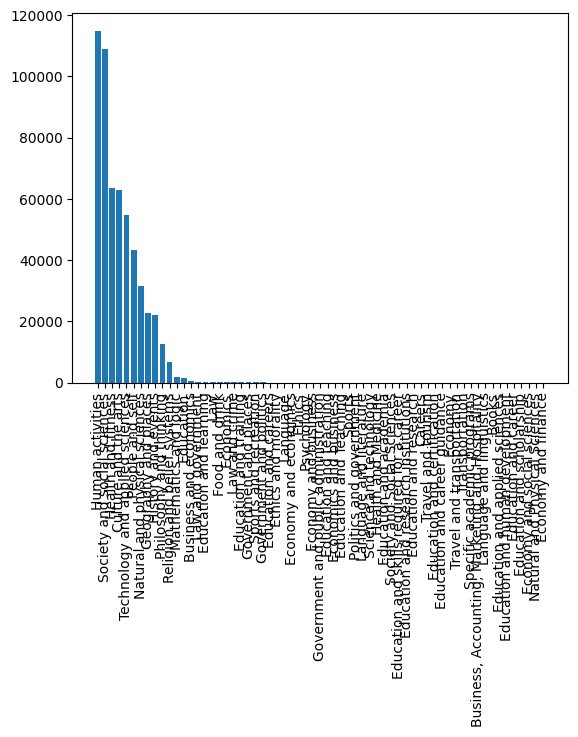

In [82]:
# Results on the taxonomy: distribution of topics (with added topics by gpt_)

df = pd.read_csv(path3)
df = df.replace({True: 1, False: 0})
df = df.replace({"negative": -1, "neutral": 0, "positive":1})

overlap_, chosen_, rejected_, all_ = category_plot(df, "topics")
plt.xticks(rotation = 90)
flattened_set = set().union(*all_)
histogram_data = {elem: sum(elem in s for s in all_) for elem in flattened_set}
sorted_histogram_data = dict(sorted(histogram_data.items(), key=lambda item: item[1], reverse=True))
plt.bar(sorted_histogram_data.keys(), sorted_histogram_data.values())
plt.savefig(f'{label}r_topic.png', bbox_inches='tight', transparent=True)

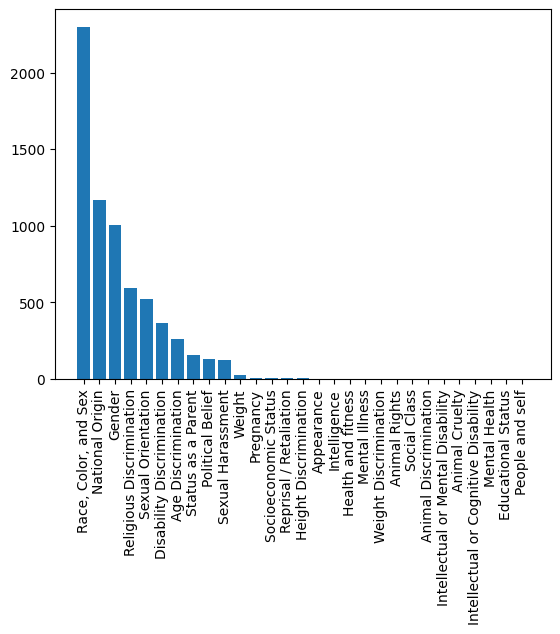

In [83]:
# Results on the taxonomy: distribution of discriminations (with added topics by gpt_)

overlap_, chosen_, rejected_, all_ = category_plot(df, "last_response_is_discriminating_against")
plt.xticks(rotation = 90)
flattened_set = set().union(*all_)
histogram_data = {elem: sum(elem in s for s in all_) for elem in flattened_set}
sorted_histogram_data = dict(sorted(histogram_data.items(), key=lambda item: item[1], reverse=True))
plt.bar(sorted_histogram_data.keys(), sorted_histogram_data.values())
plt.savefig(f'{label}r_discri.png', bbox_inches='tight', transparent=True)


last_response_is_sexually_explicit 0.003 chosen
last_response_contains_insult 0.004 chosen
last_response_breaks_privacy 0.006 chosen
last_response_is_manipulative 0.007 chosen
last_response_is_discriminatory 0.013 chosen
last_response_is_anthropomorphic 0.041 chosen
last_response_is_creative 0.042 chosen
last_response_is_refusal 0.048 chosen
last_response_sentiment 0.212 chosen
last_response_is_eloquent 0.324 chosen
last_response_is_helpful 0.782 chosen
last_response_is_coherent 0.873 chosen
last_response_is_harmless 0.942 chosen
last_response_is_honest 0.963 chosen
human_vocabulary_quality 0.985 chosen
last_response_is_sexually_explicit 0.007 rejected
last_response_contains_insult 0.011 rejected
last_response_breaks_privacy 0.012 rejected
last_response_is_manipulative 0.013 rejected
last_response_is_discriminatory 0.024 rejected
last_response_is_refusal 0.03 rejected
last_response_is_creative 0.038 rejected
last_response_is_anthropomorphic 0.048 rejected
last_response_sentiment 0.13 r

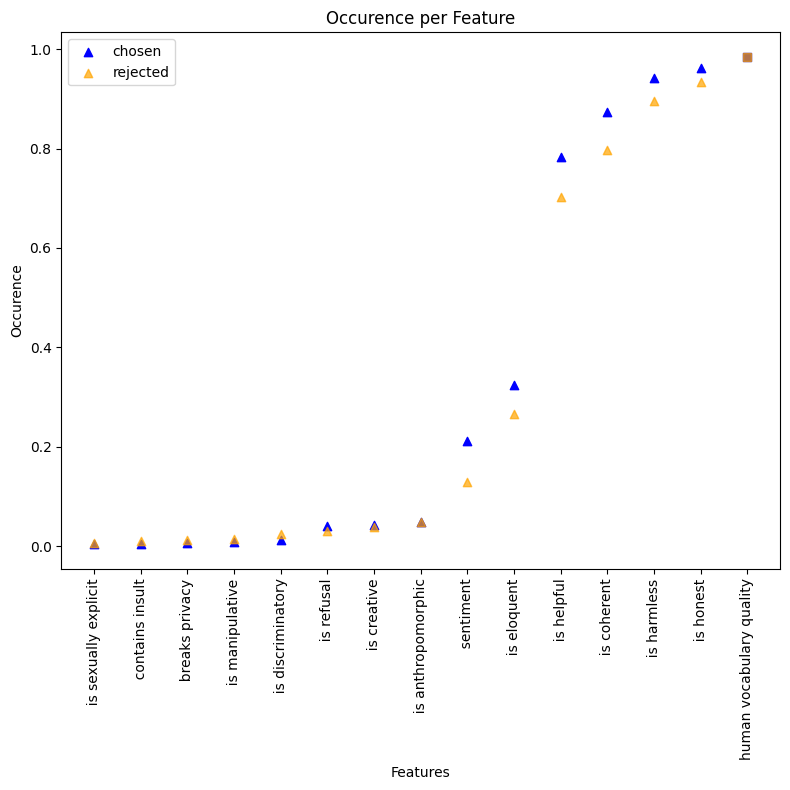

In [88]:
# Feature Representations

df_plot = df.drop(["text", "topics", "last_response_is_discriminating_against", "assistant_is_anthropomorphic", "assistant_is_coherent"], axis=1)

grouped = df_plot.groupby('preference').agg(['mean', 'std'])
plt.figure(figsize=(8,8))
marker_shapes = {'H': 's', 'A': 'o', 'L': '^'}
color_dict = {}
color_index = 0

categories = set()
for column in df.columns:
    category = column.split('_')[-1]
    categories.add(category)
categories = list(categories)

colors = plt.cm.tab10(np.linspace(0, 2, len(categories)))

mean_values = df_plot.loc[df.preference == "chosen"].drop(columns=["row_id"])._get_numeric_data().mean()
mean_values_sorted = mean_values.sort_values()
df_sorted = df[mean_values_sorted.index]

for i, (column, mean) in enumerate(mean_values_sorted.items()):
    print(column, round(mean, 3), "chosen")
    category = column.split('_')[-1]
    if 'human' in column:
        marker = marker_shapes['H']
    elif 'assistant' in column:
        marker = marker_shapes['A']
    elif 'last_response' in column:
        marker = marker_shapes['L']
    else:
        marker = 'x'
    if i == 0:
        plt.scatter(i, mean, marker=marker, label="chosen", color = "blue")
    else:
        plt.scatter(i, mean, marker=marker, color = "blue")

mean_values = df_plot.loc[df.preference == "rejected"].drop(columns=["row_id"])._get_numeric_data().mean()
mean_values_sorted = mean_values.sort_values()
df_sorted = df[mean_values_sorted.index]

for i, (column, mean) in enumerate(mean_values_sorted.items()):
    print(column, round(mean, 3), "rejected")
    category = column.split('_')[-1]
    if 'human' in column:
        marker = marker_shapes['H']
    elif 'assistant' in column:
        marker = marker_shapes['A']
    elif 'last_response' in column:
        marker = marker_shapes['L']
    else:
        marker = 'x'
    if i == 0:
        plt.scatter(i, mean, marker=marker, label="rejected", color = "orange", alpha=0.7)
    else:
        plt.scatter(i, mean, marker=marker, color = "orange", alpha=0.7)

variables = [" ".join(v.split("_")) for v in mean_values_sorted.index]
variables = [" ".join(v.split("last response")) for v in variables]

plt.xticks(range(len(mean_values_sorted)), variables, rotation=90)
plt.xlabel("Features")
plt.ylabel("Occurence")
plt.title("Occurence per Feature")
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}r_mean_cr_p.png', bbox_inches='tight', transparent=True)

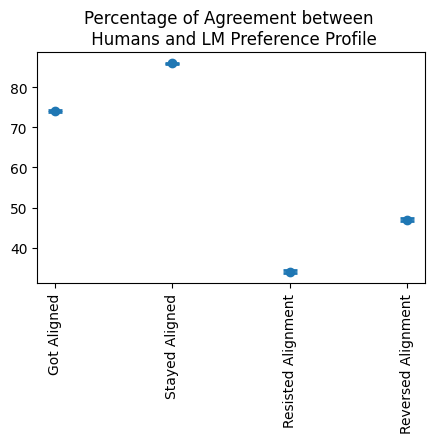

In [85]:
# Agreement rate stats

data = {
    'estimate': [74, 86, 34, 47],
    'n': [41445, 77646, 27644, 14065]
}
df = pd.DataFrame(data)
df['std_dev'] = np.sqrt((df['estimate'] / 100) * (1 - df['estimate'] / 100)/df["n"])
plt.figure(figsize=(5, 3))
plt.errorbar(x=range(len(df)), y=df['estimate'], yerr=df['std_dev']*100, fmt='o', capsize=5, capthick=2)
plt.xticks(ticks=range(len(df)), labels=['Got Aligned', 'Stayed Aligned', 'Resisted Alignment', 'Reversed Alignment'], rotation=90)
plt.title('Percentage of Agreement between \n Humans and LM Preference Profile')
plt.grid(False)
plt.show()
